In [1]:
import pickle

with open("./results/pretraining.pkl", "rb") as f:
    results = pickle.load(f)
runs_df = results["runs_df"]
no_dp_results = results["no_dp_results"]

In [2]:
# import pandas as pd 
# from tqdm import tqdm
# import wandb

# ARCHIVE_SWEEP_IDS = {}

# api = wandb.Api(timeout=60)

# # Project is specified by <entity/project-name>
# runs = api.runs("shlomihod/ydnpd-dp-ft",
#                 filters={"created_at": {"$gte": "2025-02-03T00:00:00.000000+00:00"}},
#                 # per_page=3_000
#                 )
# run_records = []

# for run in tqdm(runs):

#     run_records.append({
#         "id_": run.id,
#         "summary": run.summary._json_dict,
#         "config": {k: v for k,v in run.config.items()
#           if not k.startswith('_')},
#         "name": run.name,
#         "sweep": run.sweep.id,
#     })

# runs_df = pd.DataFrame(run_records)

# for col in ("summary", "config"):
#     runs_df = runs_df.join(pd.json_normalize(runs_df[col]))

# def extract_public_data_pointer(r):
#     if not r['public_data_pointer']:
#         family, _ = r['private_data_pointer'].split("/")
#         return f"{family}/no-pre"
#     elif isinstance(r['public_data_pointer'], list):
#         return r['public_data_pointer'][0]
#     else:
#         return r['public_data_pointer']

# runs_df['public_data_pointer'] = runs_df.apply(extract_public_data_pointer, axis=1)

# # runs_df.loc[
# #     runs_df['public_data_pointer'].str.endswith("no-pre"),
# #     'dp/private.test/auc'
# #     ] = runs_df.loc[runs_df['public_data_pointer'].str.endswith("no-pre"), 'dp.test/auc']

In [3]:
runs_df['public_data_pointer'].value_counts()

public_data_pointer
edad/2020                      800
we/gen-claude-MIX-MAX          800
we/gen-claude-MIX-UNIF         800
we/gen-MIX-UNIF                800
we/gen-llama-MIX-UNIF          800
we/sdscm-llama-3-8b            800
we/csv-llama                   800
acs/massachusetts_upsampled    800
acs/baseline_univariate        800
acs/baseline_domain            800
acs/arbitrary                  800
acs/gen-MIX-MAX                800
acs/csv-gpt                    800
acs/gen-gpt-MIX-MAX            800
acs/sdscm-gpt2                 800
acs/gen-llama-MIX-MAX          800
acs/sdscm-olmo-1b-hf           800
acs/gen-gpt-MIX-UNIF           800
acs/gen-claude-MIX-MAX         800
acs/csv-claude                 800
acs/gen-claude-MIX-UNIF        800
acs/gen-MIX-UNIF               800
acs/gen-llama-MIX-UNIF         800
acs/sdscm-llama-3-8b           800
acs/csv-llama                  800
edad/baseline_univariate       800
we/csv-claude                  800
we/gen-gpt-MIX-UNIF            800


In [4]:
runs_without_gpt2_df = runs_df.loc[~runs_df['public_data_pointer'].str.contains("gpt2")]

In [5]:
# from ydnpd.pretraining.trainer import TransformerTrainer

# no_dp_results = {pointer.split("/")[0]: [
#     TransformerTrainer.train_and_evaluate(public_data_pointer=pointer)["no-dp"]
#     for _ in range(80)]
#     for pointer in runs_df['private_data_pointer'].unique()}

In [6]:
# import pickle
# with open("./results/pretraining.pkl", "wb") as f:
#     pickle.dump({"runs_df": runs_df, "no_dp_results": no_dp_results}, f)

In [7]:
from typing import List, Optional
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots


plt.style.use(['science', 'no-latex'])

PUBLIC_DATASETS = ["acs/massachusetts_upsampled", "edad/2020", "we/2018"]
CATEGORY_ORDER = ["Without pretraining", "Public", "Baseline", "Arbitrary", "CSV", "Agent", "SD-SCM"]

plt.rcParams.update({
    'font.size': 14,  # Base font size
    'axes.labelsize': 16,  # Size of axis labels
    'axes.titlesize': 16,  # Size of plot title
    'xtick.labelsize': 14,  # Size of x-tick labels
    'ytick.labelsize': 14,  # Size of y-tick labels
    'legend.fontsize': 14,  # Size of legend text
})


def validate_dataframe(df: pd.DataFrame) -> None:
    """
    Validate the input DataFrame has required columns and format.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to validate
    
    Raises
    ------
    ValueError
        If DataFrame doesn't meet requirements
    """
    if 'category' not in df.columns:
        raise ValueError("DataFrame must contain 'category' column")
    
    # Check for epsilon columns
    eps_cols = [col for col in df.columns if col.startswith('eps=')]
    if not eps_cols:
        raise ValueError("DataFrame must contain epsilon columns (format: 'eps=X')")
    
    # Verify epsilon columns contain numeric data
    for col in eps_cols:
        if not pd.to_numeric(df[col], errors='coerce').notna().all():
            raise ValueError(f"Column {col} must contain only numeric values")

def get_epsilon_columns(df: pd.DataFrame) -> List[str]:
    """Extract and sort epsilon columns from DataFrame."""
    eps_cols = [col for col in df.columns if col.startswith('eps=')]
    
    # Extract numeric values and sort
    def get_eps_value(col: str) -> float:
        return float(col.split('=')[1])
    
    return sorted(eps_cols, key=get_eps_value)

def get_color_coding(val: float, col_values: np.ndarray) -> str:
    """
    Get LaTeX color coding based on value's rank.
    
    Parameters
    ----------
    val : float
        Value to check
    col_values : np.ndarray
        All values in the column
    
    Returns
    -------
    str
        LaTeX color command or empty string
    """
    sorted_vals = sorted(set(col_values), reverse=True)
    rank = sorted_vals.index(val)
    
    color_map = {
        0: 'gold',
        1: 'silver',
        2: 'bronze'
    }
    
    return f'\\cellcolor{{{color_map[rank]}!30}}' if rank in color_map else ''

def generate_latex_table(
    df: pd.DataFrame,
    caption: str = "Results by method and epsilon value",
    label: str = "tab:epsilon_comparison"
) -> str:
    """
    Generate a LaTeX table from a pandas DataFrame with color-coding for top 3 values.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
            - 'category' column
            - 'eps=X' columns with numeric values
        Optional:
            - 'Method' column for detailed tables
    caption : str
        Table caption
    label : str
        Table label for referencing
    
    Returns
    -------
    str
        LaTeX table code
    """
    # Validate input
    validate_dataframe(df)
    
    # Determine table type and get epsilon columns
    is_detailed = 'Method' in df.columns
    eps_cols = get_epsilon_columns(df)
    
    # Start building table
    latex = [
        '\\begin{table}[h!]',
        '    \\centering',
        f'    \\caption{{{caption}}}',
        f'    \\label{{{label}}}',
        '    \\begin{tabular}{l' + 'c' * len(eps_cols) + '}',
        '    \\toprule'
    ]
    
    # Header row
    header = ['Method Category' if not is_detailed else 'Method']
    header.extend([f'$\\varepsilon={col.split("=")[1]}$' for col in eps_cols])
    latex.append('    ' + ' & '.join(header) + ' \\\\')
    latex.append('    \\midrule')
    
    # Process data rows
    prev_category = None
    for idx, row in df.iterrows():
        # Add category separator if needed
        print(is_detailed, prev_category, row['category'])
        if ((is_detailed and prev_category is not None and row['category'] != prev_category)
        or (not is_detailed and prev_category in {"Without pretraining", "Public", "Baseline", "Arbitrary"})):
            latex.append('    \\arrayrulecolor{black!50!}\\midrule')
        
        # Build row content
        row_latex = [row['Method'] if is_detailed else row['category']]
        for col in eps_cols:
            val = row[col]
            color = get_color_coding(val, df[col].values)
            row_latex.append(f'{color}{val:.3f}')
        
        latex.append('    ' + ' & '.join(row_latex) + ' \\\\')
        
        # if is_detailed:
        prev_category = row['category']
    
    # Close table
    latex.extend([
        '    \\bottomrule',
        '    \\end{tabular}',
        '\\end{table}'
    ])
    
    return '\n'.join(latex)

METHOD_ORDER = ['Without pretraining',
 'Public',
 'Baseline (Domain)',
 'Baseline (Univariate)',
 'Arbitrary',
 'CSV (Claude 3.5 Sonnet)',
 'CSV (GPT-4o)',
 'CSV (Llama 3.3 70B)',
 'Agent (Claude 3.5 Sonnet MIX-UNIF)',
 'Agent (Claude 3.5 Sonnet MIX-MAX)',
 'Agent (GPT-4o MIX-UNIF)',
 'Agent (GPT-4o MIX-MAX)',
 'Agent (Llama 3.3 70B MIX-UNIF)',
 'Agent (Llama 3.3 70B MIX-MAX)',
 'Agent (MIX-UNIF)',
 'Agent (MIX-MAX)',
 'SD-SCM (GPT-2)',
 'SD-SCM (Llama 3.1 8B)',
 'SD-SCM (OLMo 1B)']

def build_table(plot_df, viz_unit):
    def extract_method_label(r):
        model_format = {"gpt": "GPT-4o",
        "gpt2": "GPT-2",
        "claude": "Claude 3.5 Sonnet",
        "llama": "Llama 3.3 70B",
        "llama-3-8b": "Llama 3.1 8B",
        "olmo-1b-hf": "OLMo 1B"
        }
        dataset_name = r["public_data_pointer"].split("/")[1]

        if dataset_name.startswith("csv"):
            name = model_format[dataset_name.split("-")[1]]
        
        elif dataset_name.startswith("sdscm"):
            name = model_format[dataset_name.split("-", 1)[1]]

        elif dataset_name.startswith("gen"):
            parts = dataset_name[4:].split("MIX")
            model = parts[0][:-1].title()
            name =  (
                (model_format[parts[0][:-1]]if parts[0] else "")
                + f" MIX{parts[1]}"
                ).strip()

        elif dataset_name.startswith("baseline"):
            name = dataset_name.split("_")[1].title()

        else:
            name = ""

        return r["category"] + (f" ({name})" if name else "")


    paper_df = (plot_df
    .groupby(["epsilon", 'category'] + (['public_data_pointer'] if viz_unit == "dataset" else []))[
        "dp/private.test/auc"]
        .mean()
        .round(3)
        .unstack(level=0)
        .reset_index()
        )

    if viz_unit == "dataset":
        df = (paper_df
        .assign(Method=pd.Categorical(paper_df.apply(extract_method_label, axis=1), categories=METHOD_ORDER, ordered=True))
        .drop(columns=["public_data_pointer"])
        .sort_values("Method")
        .reset_index(drop=True)
        )

        df = df[["category", "Method"] + [col for col in df.columns if col not in {"Method", "category"}]]
        df.columns = ["category", "Method"] + [fr"eps={col}" for col in df.columns[2:]]

    else:
        df = (paper_df
        .assign(category=pd.Categorical(paper_df["category"], categories=CATEGORY_ORDER, ordered=True))
        .sort_values("category")
        .reset_index(drop=True)
        )

        df = df[["category"] + [col for col in df.columns if col not in {"category"}]]
        df.columns = ["category"] + [fr"eps={col}" for col in df.columns[1:]]


    return df

def plot_metrics(data_prefix, runs_df, viz_unit, no_dp_results=None,
                caption=None,
                 with_legend=True, figsize=(10, 6)):
    """
    Create a line plot showing AUC vs Epsilon for different dataset categories,
    with a horizontal line showing the non-DP baseline performance.
    """

    if viz_unit not in {"dataset", "category"}:
        raise ValueError("viz_unit")

    fig = plt.figure(figsize=figsize)
    
    if with_legend:
        # Narrower plot area to make room for legend
        ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])  # [left, bottom, width, height]
    else:
        # Use full width when no legend
        ax = fig.add_axes([0.1, 0.1, 0.88, 0.8])
    
    # Define category mapping function
    def get_category(pointer):
        if f'{data_prefix}/no-pre' in pointer:
            return 'Without pretraining'
        elif pointer in PUBLIC_DATASETS:
            return "Public"
        elif f'{data_prefix}/baseline' in pointer:
            return 'Baseline'
        elif f'{data_prefix}/arbitrary' in pointer:
            return 'Arbitrary'
        elif f'{data_prefix}/csv' in pointer:
            return 'CSV'
        elif f'{data_prefix}/gen' in pointer:
            return 'Agent'
        elif f'{data_prefix}/sdscm' in pointer:
            return 'SD-SCM'
    

    # Filter and prepare data
    plot_data = (runs_df
        .loc[runs_df['private_data_pointer'].str.startswith(data_prefix)]
    )
    plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)

    # Define color mapping
    color_map = {
        'Without pretraining': 'red',
        'Baseline': 'grey',
        'Arbitrary': 'blue',
        'Public': 'magenta',
    'Arbitrary': 'blue',                 # Keep blue
    'CSV': '#228B22',                    # Green (X)
    "Agent": '#FF8C00',                  # Orange (Y)
    'SD-SCM': '#8B4513'                  # Brown (Z)
    }
    
    linewidth_not_core = 1.0 if viz_unit == "dataset" else 2.0
    alpha_not_core = 0.7 if viz_unit == "dataset" else 1

    linewidth_map = {
        'Without pretraining': 2.0,
        'Baseline': 2.0,
        'Public': 2.0,
        'Arbitrary': linewidth_not_core,
        'CSV': linewidth_not_core,
        "Agent": linewidth_not_core,
        'SD-SCM': linewidth_not_core,
    }

    alpha_map = {
        'Without pretraining': 1,
        'Baseline': 1,
        'Public': 1,
        'Arbitrary': 1,
        'CSV': alpha_not_core,
        "Agent": alpha_not_core,
        'SD-SCM': alpha_not_core
    }

    # Plot each category separately
    legend_handles = []
    legend_labels = []
    
    if viz_unit == "dataset":
        plot_data = (plot_data
                     .groupby(['category', 'public_data_pointer', 'epsilon'])
                     ['dp/private.test/auc']
                     .agg(['mean', 'std', 'size'])
                     .rename({"mean": "dp/private.test/auc"}, axis=1)
                     .reset_index())

        # Calculate standard error using the actual sample size for each group
        plot_data['se'] = plot_data['std'] / np.sqrt(plot_data['size'])
        estimator, errorbar, units = None, None, "public_data_pointer"
         
    else:
        estimator, errorbar, units = "mean", ("ci", 95), None

    for category in CATEGORY_ORDER:
        category_data = plot_data[plot_data['category'] == category]
        
        _ = sns.lineplot(
            data=category_data,
            x='epsilon',
            y='dp/private.test/auc',
            units=units,
            estimator=estimator,
            errorbar=errorbar,
            err_style="bars", #errorbar=("se", 2),
            color=color_map[category],
            alpha=alpha_map[category],
            linewidth=linewidth_map[category],
            marker='o',
            markersize=6,
            label='_nolegend_',  # Suppress automatic legend entries
            ax=ax
        )
        
        # if viz_unit == "dataset":
        #     for pointer in category_data['public_data_pointer'].unique():
        #         pointer_data = category_data[category_data['public_data_pointer'] == pointer]
        #         ax.fill_between(
        #             pointer_data['epsilon'],
        #             pointer_data['dp/private.test/auc'] - pointer_data['se'],
        #             pointer_data['dp/private.test/auc'] + pointer_data['se'],
        #             alpha=0.2,
        #             color=color_map[category]
        #         )

        # Create custom legend entry for this category
        legend_handles.append(plt.Line2D([0], [0], color=color_map[category], 
                                    alpha=alpha_map[category],
                                    linewidth=linewidth_map[category],
                                    marker='o', markersize=6,
                                    markerfacecolor=color_map[category]))
        legend_labels.append(category)

    # Customize the plot
    ax.set_xscale('log')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('AUC')
    # ax.set_title(f'AUC vs Epsilon by Dataset ({data_prefix.upper()} Data)')

    # Set x-axis ticks
    unique_epsilons = sorted(plot_data['epsilon'].unique())
    ax.set_xticks(unique_epsilons)
    ax.set_xticklabels(unique_epsilons)
    
    # Add horizontal line for no-DP baseline if needed
    if no_dp_results is not None and data_prefix in no_dp_results:
        baseline_auc = np.mean([result['test/auc'] for result in no_dp_results[data_prefix]])
        ax.axhline(y=baseline_auc, color='black', linestyle='--')
        # Add baseline to legend
        legend_handles.append(plt.Line2D([0], [0], color='black', linestyle='--'))
        legend_labels.append('No DP baseline')

    # Set legend with custom handles
    # ax.legend(legend_handles, legend_labels)

    if with_legend:
        ax.legend(legend_handles, legend_labels,
                 bbox_to_anchor=(1.05, 0.5),
                 loc='center left',
                 borderaxespad=0,
                 frameon=False)

    plt.tight_layout()  # Adjusts layout


    paper_df = build_table(plot_data, viz_unit)
    tab = generate_latex_table(paper_df, caption=caption)

    return fig, tab


def save_result(name, fig, latex_table):
    fig.savefig(f"./plots/{name}.pdf", bbox_inches='tight')
    with open(f"./tables/{name}.tex", "w") as f:
        f.write(latex_table)

def create_caption(dataset_name, viz_unit, is_best=False):
    return f"Mean AUC of the DP model on {dataset_name.upper()} data after pretraining, grouped by generation method{' category' if viz_unit == 'category' else ''}. The mean is calculated across the {'DP finetuning ' if is_best else ''}hyperparameter space{' when best pretraining hyperparameter configuration is choosen for the pretraining step' }, with 10 runs per hyperparameter configuration."

## Mean - Per Dataset

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM
True SD-SCM SD-SCM
*** Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


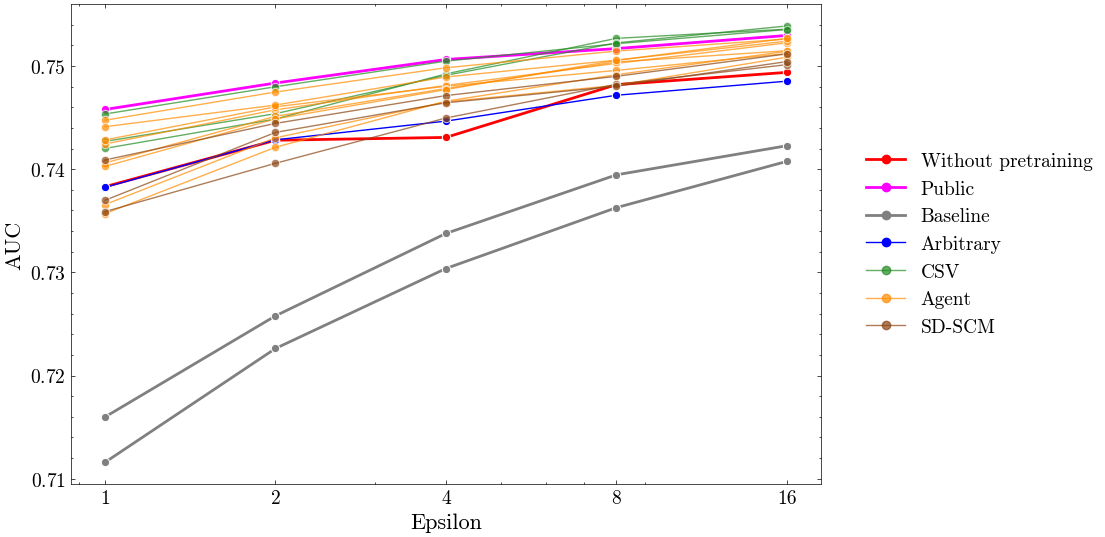

In [8]:
caption = create_caption("acs", "dataset", is_best=False)
f, tab = plot_metrics("acs", runs_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-dataset-acs", f, tab)
print(f"*** {caption}")

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM
*** Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


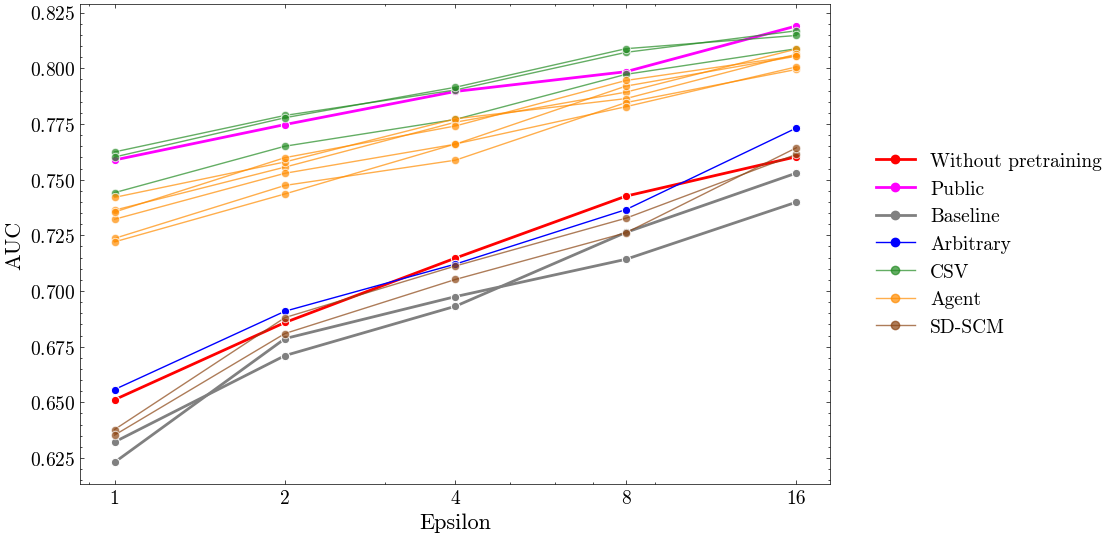

In [9]:
caption = create_caption("edad", "dataset", is_best=False)
f, tab = plot_metrics("edad", runs_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-dataset-edad", f, tab)
print(f"*** {caption}")

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM
True SD-SCM SD-SCM
*** Mean AUC of the DP model on WE data after pretraining, grouped by generation method. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


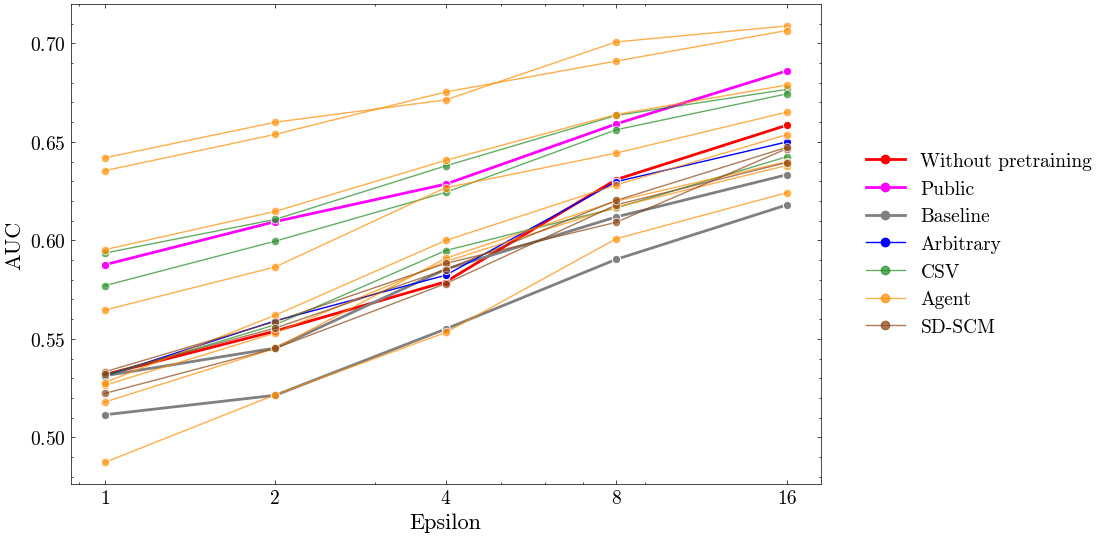

In [10]:
caption = create_caption("we", "dataset", is_best=False)
f, tab = plot_metrics("we", runs_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-dataset-we", f, tab)
print(f"*** {caption}")

## Mean - Category

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM
*** Mean AUC of the DP model on ACS data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


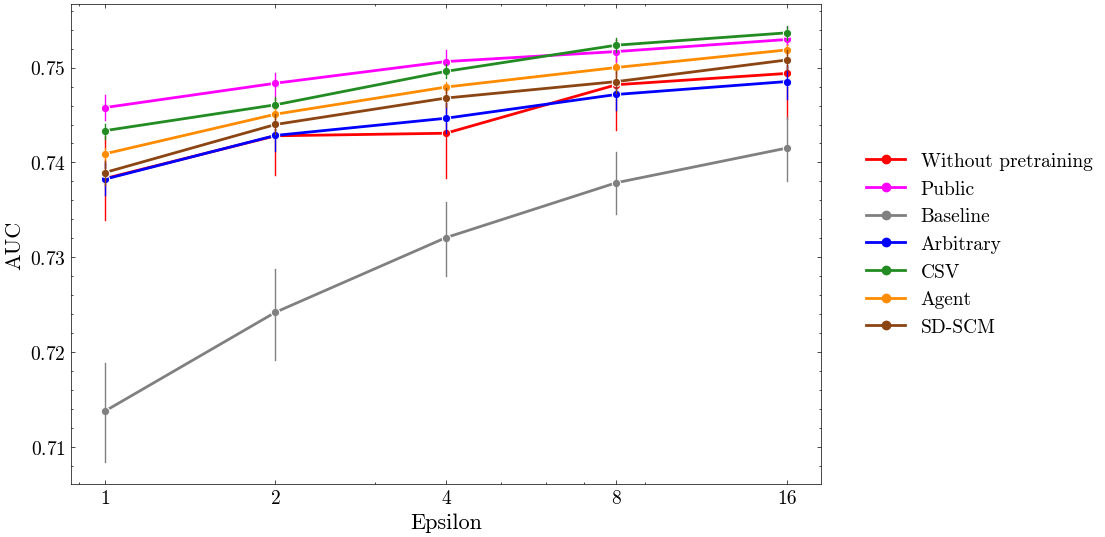

In [11]:
caption = create_caption("acs", "category", is_best=False)
f, tab = plot_metrics("acs", runs_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-category-acs", f, tab)
print(f"*** {caption}")

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM
*** Mean AUC of the DP model on EDAD data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


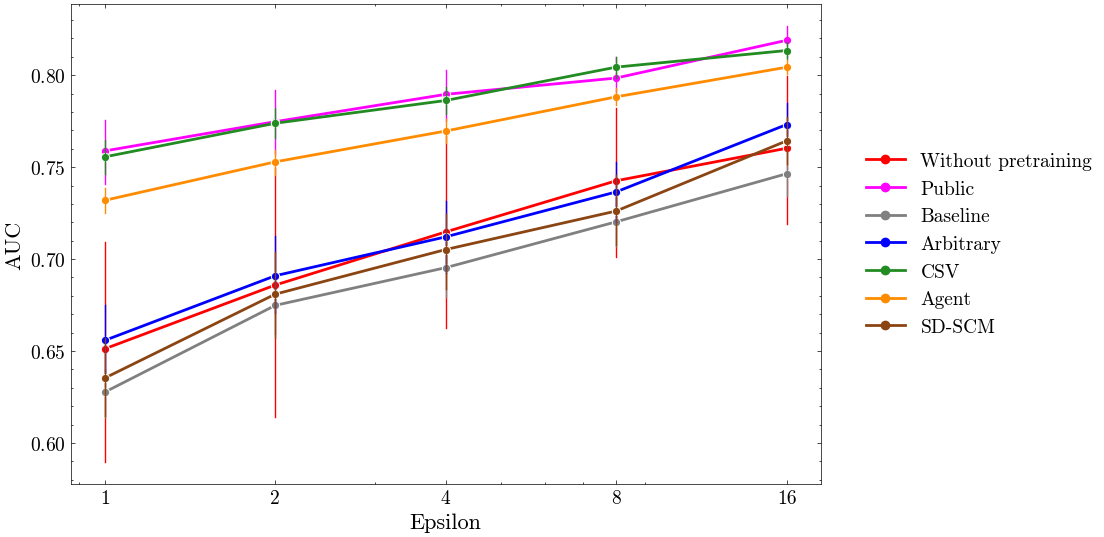

In [12]:
caption = create_caption("edad", "category", is_best=False)
f, tab = plot_metrics("edad", runs_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-category-edad", f, tab)
print(f"*** {caption}")

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM
*** Mean AUC of the DP model on WE data after pretraining, grouped by generation method category. The mean is calculated across the hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


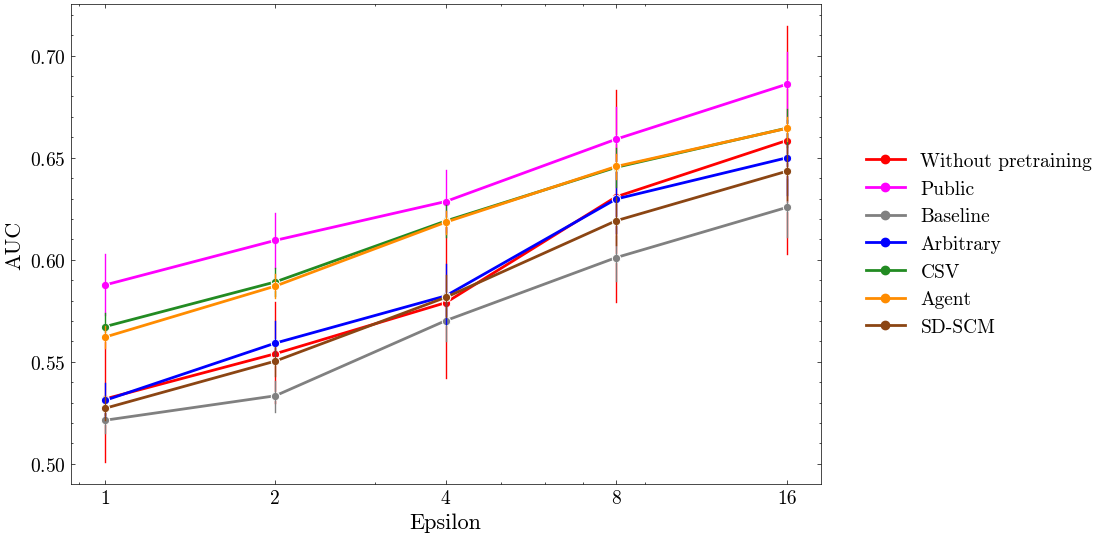

In [13]:
caption = create_caption("we", "category", is_best=False)
f, tab = plot_metrics("we", runs_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-category-we", f, tab)
print(f"*** {caption}")

## Choose best hparams on pre

In [14]:
# Define the pre-training hyperparameter columns order
pre_hparam_cols = [col for col in runs_df.columns if col.startswith("pre_")]

# Calculate mean performance for each hyperparameter configuration
avg_performance = (
    runs_df.groupby(["epsilon", "public_data_pointer"] + pre_hparam_cols)
    ["pre/public.test/auc"]
    .mean()
)

# Get the hyperparameter configurations that achieve the best mean performance
best_pre_hparams = avg_performance.groupby(level=["epsilon", "public_data_pointer"]).idxmax()

# Get indices of all runs matching the best configurations
idx = []
for (eps, pdp), pre_hparams in best_pre_hparams.items():
    # First ensure epsilon and public_data_pointer match
    mask = (runs_df['epsilon'] == eps) & (runs_df['public_data_pointer'] == pdp)
    
    # Then match all hyperparameters - using only the hyperparameter values (last 3 values)
    for col, val in zip(pre_hparam_cols, pre_hparams[-3:]):  # Take last 3 values which are the actual hyperparameters
        mask &= (runs_df[col] == val)
    
    idx.extend(runs_df[mask].index)

# Assert we have only one config per (epsilon, pdp)
config_counts = runs_df.loc[idx].groupby(["epsilon", "public_data_pointer"])[pre_hparam_cols].nunique()
assert (config_counts == 1).all().all(), "Found multiple hyperparameter configurations for some (epsilon, pdp) pairs"

# Create final dataframe
runs_best_on_pre_df = pd.concat([
    runs_df.loc[idx].reset_index(drop=True),
    runs_df.loc[runs_df["public_data_pointer"].str.contains("no-pre")]
])


runs_best_on_pre_without_gpt2_df = runs_best_on_pre_df.loc[~runs_best_on_pre_df['public_data_pointer'].str.contains("gpt2")]

In [15]:
runs_best_on_pre_df["private_data_pointer"].value_counts()

private_data_pointer
acs/national    1900
we/2023         1900
edad/2023       1600
Name: count, dtype: int64

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM
True SD-SCM SD-SCM
*** Mean AUC of the DP model on ACS data after pretraining, grouped by generation method. The mean is calculated across the DP finetuning hyperparameter space when best pretraining hyperparameter configuration is choosen for the pretraining step, with 10 runs per hyperparameter configuration.


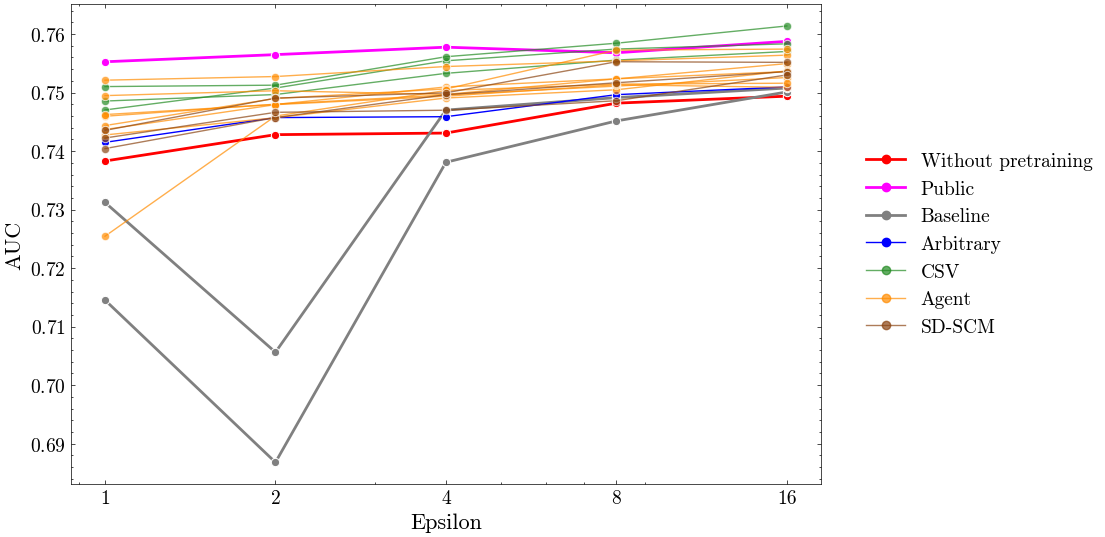

In [16]:
caption = create_caption("acs", "dataset", is_best=True)
f, tab = plot_metrics("acs", runs_best_on_pre_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-dataset-acs", f, tab)
print(f"*** {caption}")

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM


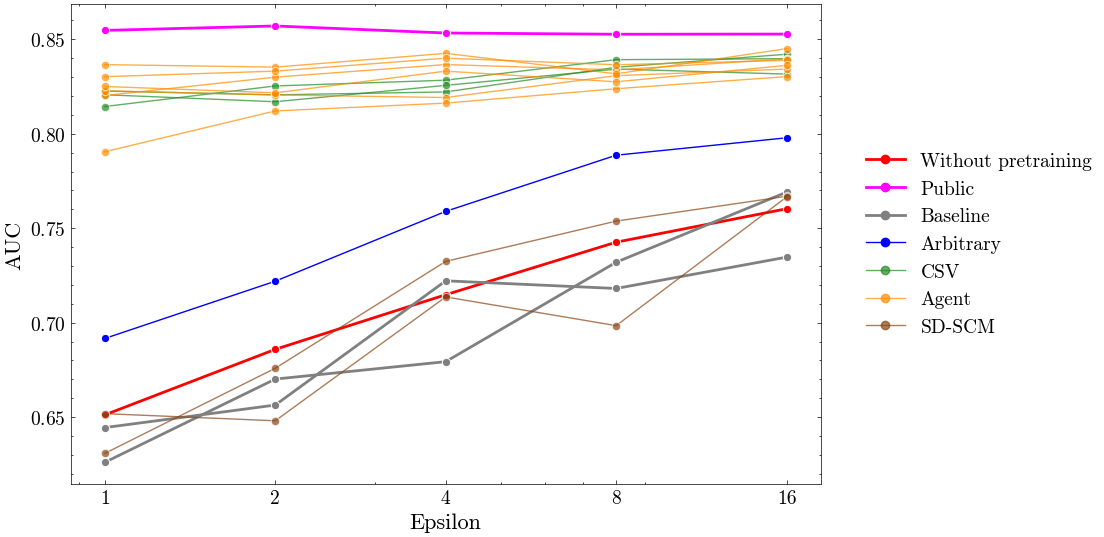

In [17]:
caption = create_caption("edad", "dataset", is_best=True)
f, tab = plot_metrics("edad", runs_best_on_pre_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-dataset-edad", f, tab)

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


True None Without pretraining
True Without pretraining Public
True Public Baseline
True Baseline Baseline
True Baseline Arbitrary
True Arbitrary CSV
True CSV CSV
True CSV CSV
True CSV Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent Agent
True Agent SD-SCM
True SD-SCM SD-SCM
True SD-SCM SD-SCM


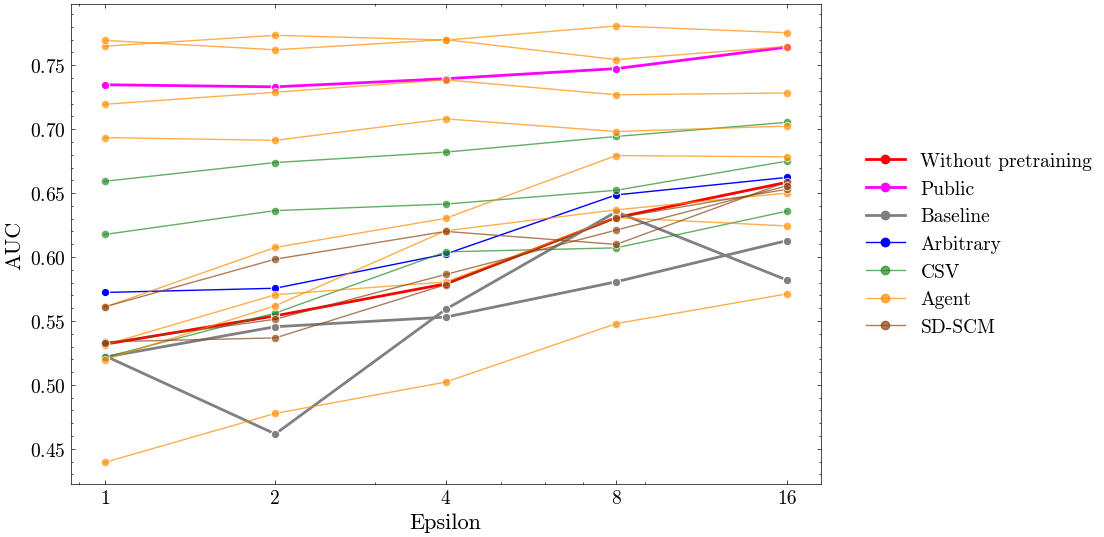

In [18]:
caption = create_caption("we", "dataset", is_best=True)
f, tab = plot_metrics("we", runs_best_on_pre_df, viz_unit="dataset", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-dataset-we", f, tab)

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM


/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


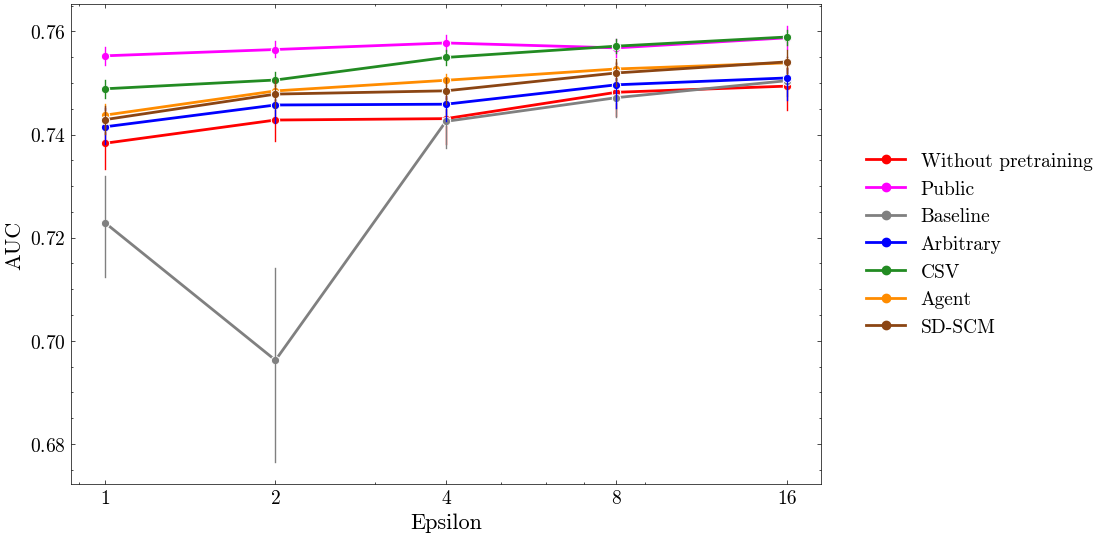

In [19]:
caption = create_caption("acs", "category", is_best=True)
f, tab = plot_metrics("acs", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-category-acs", f, tab)

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM


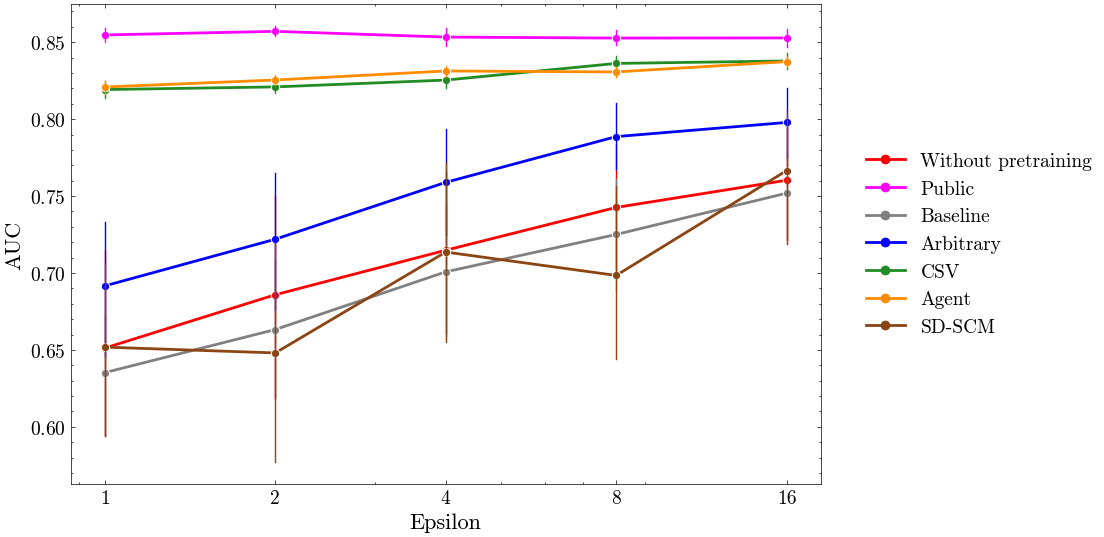

In [20]:
caption = create_caption("edad", "category", is_best=True)
f, tab = plot_metrics("edad", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-category-edad", f, tab)

/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:298: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[:, 'category'] = plot_data.loc[:, 'public_data_pointer'].apply(get_category)
/var/folders/g7/7j0xpgws5pzfdx__l8pmdvh40000gp/T/ipykernel_65263/4273638005.py:422: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts layout


False None Without pretraining
False Without pretraining Public
False Public Baseline
False Baseline Arbitrary
False Arbitrary CSV
False CSV Agent
False Agent SD-SCM


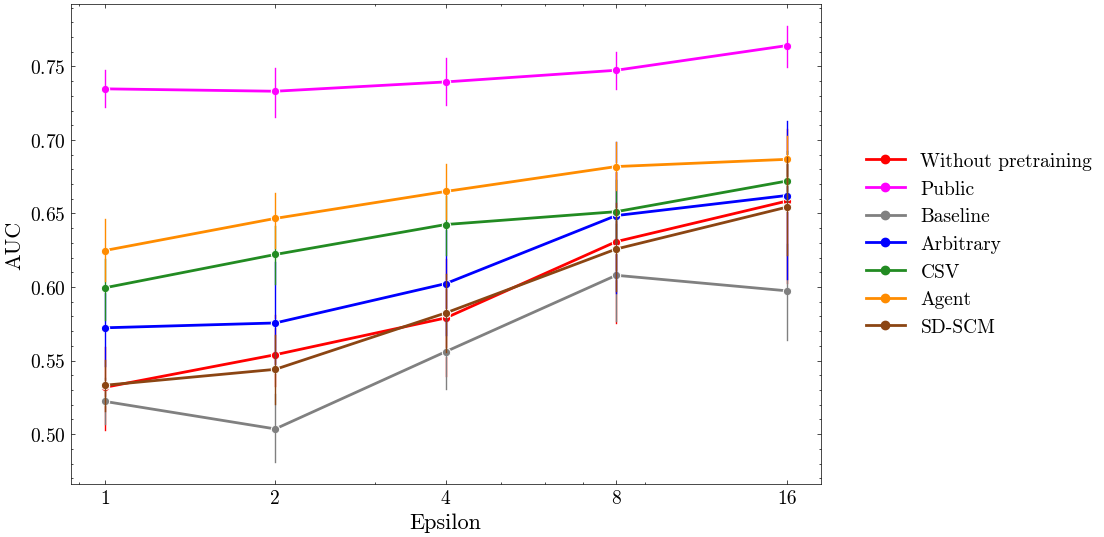

In [21]:
caption = create_caption("we", "category", is_best=True)
f, tab = plot_metrics("we", runs_best_on_pre_without_gpt2_df, viz_unit="category", with_legend=True,
                      caption=caption)
save_result("pretraining-best-hparams-category-we", f, tab)